https://github.com/AIMLModeling/HJM

The Heath-Jarrow-Morton Model (HJM Model) is used to model forward interest rates using a differential equation that allows for randomness. I explained the assumptions of HJM model, then demonstrated how to calibrate and use it for security pricing in Python. https://www.youtube.com/watch?v=Pky6sUat0wE

In [4]:
# %pip install progressbar2

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import copy as copylib
from progressbar import *
import pandas as pd
import numpy
#%pylab
from matplotlib import pylab
from pylab import *
pylab.rcParams['figure.figsize'] = (16, 4.5)
numpy.random.seed(0)

Plotting dataframe

,1/12/2022,1/2/2022,1,1.5,2,2.5,3,3.5,4,4.5,...,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25
time,,,,,,,,,,,,,,,,,,,,,
1,0.057734,0.064382,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,...,0.034194,0.034772,0.035371,0.035985,0.036612,0.037252,0.037902,0.038562,0.039231,0.039908
2,0.057680,0.064506,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,...,0.033790,0.034437,0.035108,0.035798,0.036504,0.037224,0.037959,0.038705,0.039461,0.040227
3,0.057758,0.064410,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,...,0.032706,0.033294,0.033907,0.034539,0.035188,0.035853,0.036533,0.037224,0.037927,0.038639
4,0.057430,0.064103,0.066942,0.066215,0.064904,0.063462,0.062006,0.060601,0.059252,0.057933,...,0.031325,0.031891,0.032486,0.033106,0.033748,0.034409,0.035088,0.035784,0.036493,0.037214
5,0.057412,0.063978,0.066358,0.065502,0.064168,0.062722,0.061262,0.059849,0.058488,0.057157,...,0.030119,0.030667,0.031250,0.031862,0.032499,0.033161,0.033844,0.034546,0.035264,0.035997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,0.046421,0.045093,0.042471,0.042081,0.042663,0.043224,0.043640,0.043940,0.044156,0.044314,...,0.040260,0.040098,0.039950,0.039813,0.039687,0.039571,0.039464,0.039365,0.039273,0.039187
1261,0.046233,0.044976,0.042452,0.042131,0.042726,0.043285,0.043699,0.043998,0.044214,0.044374,...,0.040307,0.040147,0.039999,0.039863,0.039737,0.039621,0.039514,0.039414,0.039320,0.039233
1262,0.046348,0.045311,0.043295,0.043266,0.043963,0.044565,0.045003,0.045323,0.045560,0.045739,...,0.041276,0.041118,0.040972,0.040840,0.040718,0.040607,0.040505,0.040411,0.040324,0.040244


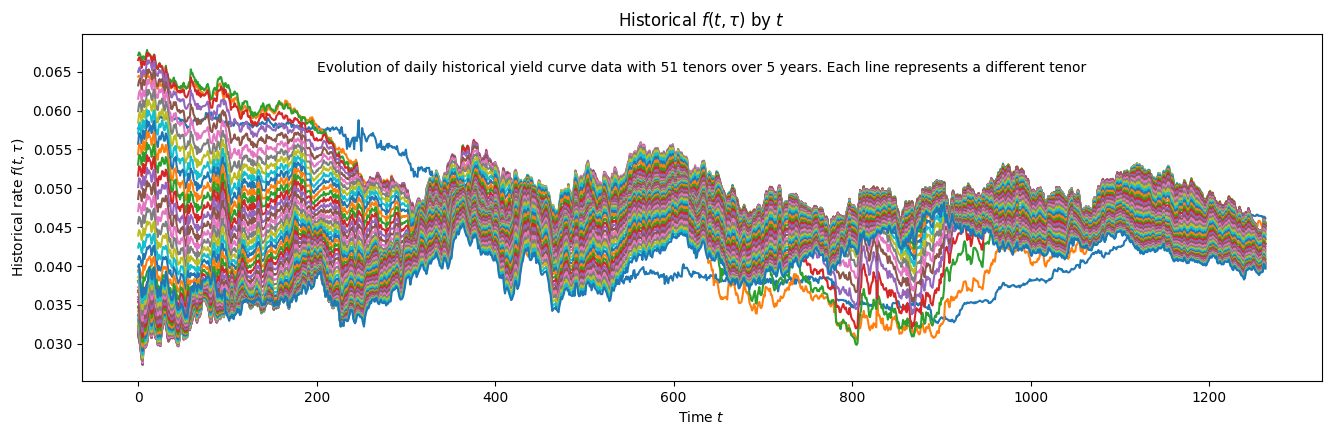

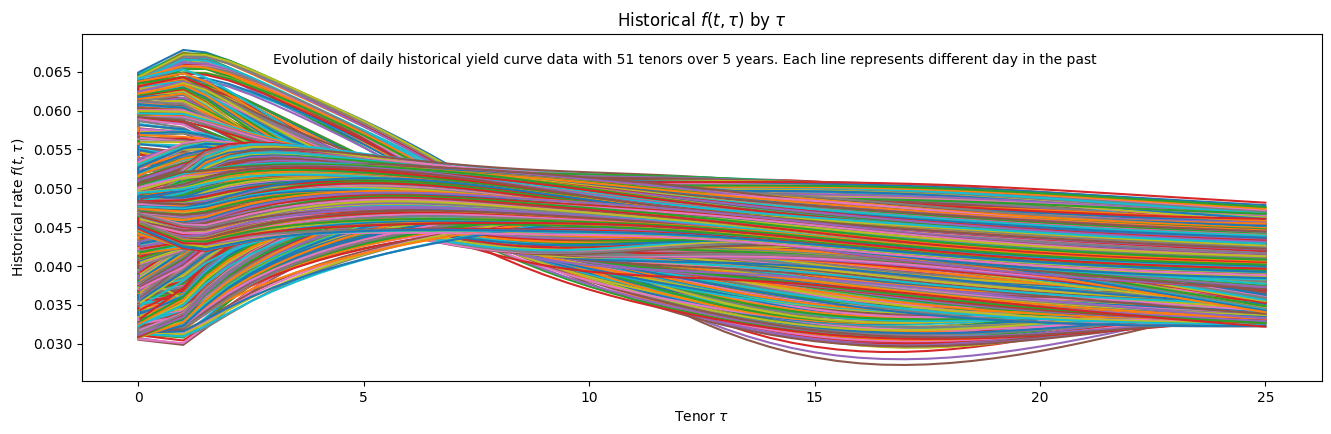

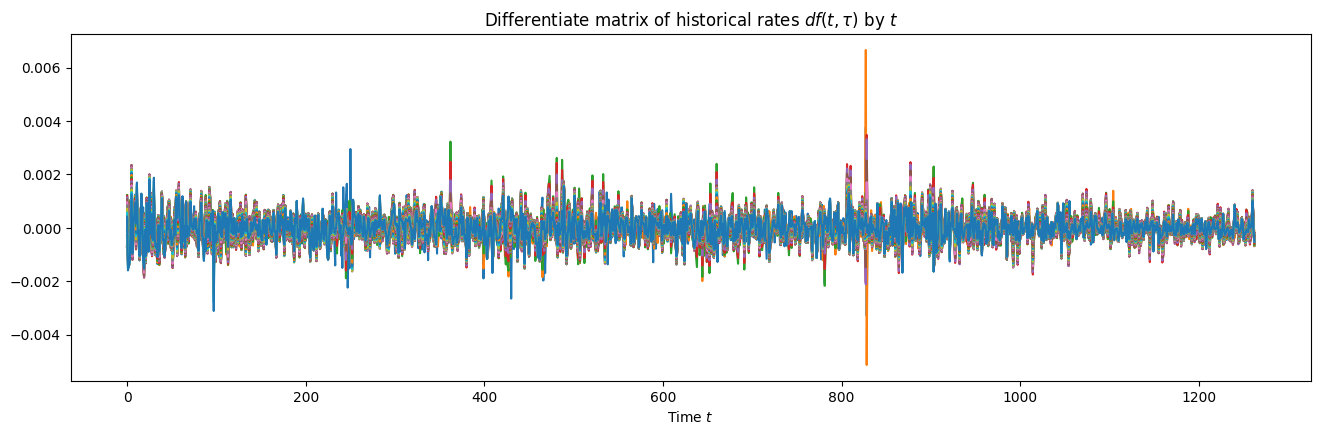

In [6]:

dataframe =  pd.read_csv('hjm_data.csv').set_index('time') / 100 # Convert interest rates to %
pd.options.display.max_rows = 10
display(dataframe)

hist_timeline = list(dataframe.index)
tenors = [eval(x) for x in dataframe.columns]
hist_rates = matrix(dataframe)

plot(hist_rates), xlabel(r'Time $t$'), 
ylabel(r'Historical rate $f(t,\tau)$'), text(200, 0.065, r'Evolution of daily historical yield curve data with 51 tenors over 5 years. Each line represents a different tenor'),
title(r'Historical $f(t,\tau)$ by $t$'), show();

plot(tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), 
ylabel(r'Historical rate $f(t,\tau)$'), text(3, 0.066, r'Evolution of daily historical yield curve data with 51 tenors over 5 years. Each line represents different day in the past'),
title(r'Historical $f(t,\tau)$ by $\tau$'), show();

diff_rates = diff(hist_rates, axis=0)
assert(hist_rates.shape[1]==diff_rates.shape[1])
plot(diff_rates), xlabel(r'Time $t$'), title(r'Differentiate matrix of historical rates $df(t,\tau)$ by $t$'), show();

Calculating PCA

Sigma shape : (51, 51)
Eigenvalues :
[2.02884026e-03 4.62889282e-04 1.63677691e-04 8.47948767e-05
 5.10134525e-05 3.26491422e-05 1.53862297e-05 3.90765854e-06
 1.45385608e-06 3.99451236e-07 7.74123147e-08 2.25094244e-08
 6.81015644e-09 2.04941493e-09 8.30654947e-10 3.18422245e-10
 1.69855176e-10 1.20686709e-10 8.18818675e-11 4.65678731e-11
 2.41691330e-11 1.26818337e-11 7.83625737e-12 4.07031443e-12
 2.61695754e-12 1.78999754e-12 1.07235513e-12 6.26514590e-13
 3.36669717e-13 2.89485567e-13 2.09893602e-13 2.02355326e-13
 1.20792341e-13 9.80002789e-14 7.30539045e-14 5.84913799e-14
 5.01860748e-14 4.50412042e-14 4.25136406e-14 3.00503730e-14
 1.99691778e-14 1.44930849e-14 8.67088778e-15 6.67527493e-15
 5.37130190e-15 4.23439662e-15 2.52346486e-15 1.26740799e-15
 4.34860200e-17 1.87381026e-16 2.51650267e-16]
Principal eigenvalues
[0.00202884 0.00046289 0.00016368]

Principal eigenvectors
[[ 0.00351033 -0.00972625 -0.00111508]
 [ 0.05665586 -0.16326718  0.27313784]
 [ 0.10114279 -0.2389149 

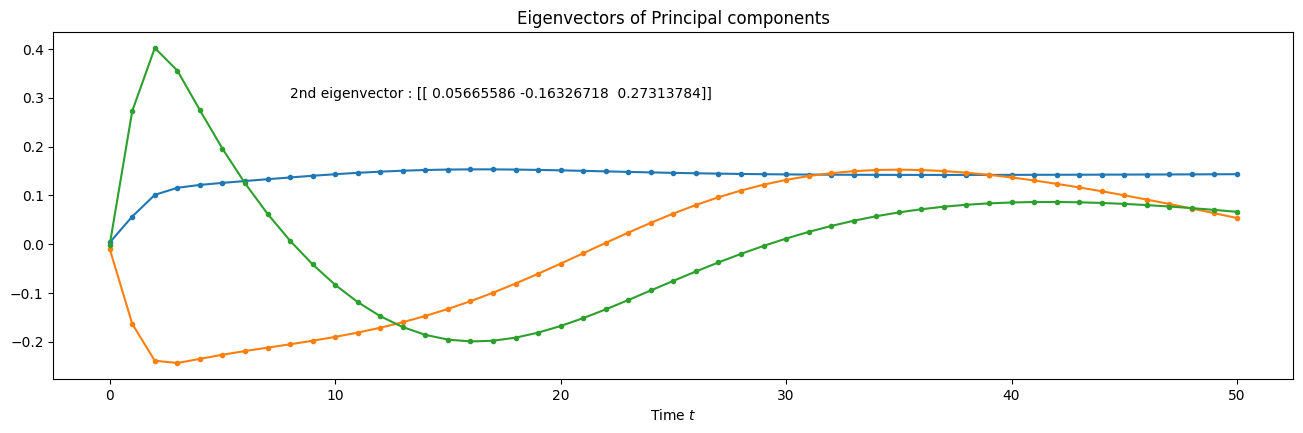

In [7]:
# Calculate covariance matrix
sigma = cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))
sigma *= 252 # 252 trading days in a year
eigval, eigvec = linalg.eig(sigma) # Eigenvectors represent the principal axes of variance, and eigenvalues represent the magnitude of that variance.
eigvec=matrix(eigvec)
assert type(eigval) == ndarray # assert checks if a condition is true
assert type(eigvec) == matrix
print("Eigenvalues :")
print(eigval)
factors=3 # Sets the number of principal components to keep
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # selects 3 highest principal component first in the array
princ_eigval = array([eigval[i] for i in index_eigvec])
princ_comp = hstack([eigvec[:,i] for i in index_eigvec]) # horizontally rearrange eigenvalues

print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp)
print()
eigenvector1_text=str(princ_comp[1])
print("eigenvectors of PC1", eigenvector1_text)

plot(princ_comp, marker='.'), title('Eigenvectors of Principal components'), 
xlabel(r'Time $t$'), text(8, 0.3, '2nd eigenvector : {}'.format(eigenvector1_text)),show();

An eigenvector e_i is a vector, or a one-dimensional array, that defines the shape of the i-th principal component (PC) and variance = eigenvalue(lambda)

Thus volatility(sigma) = sqrt(eigenvalue) * eigenvector

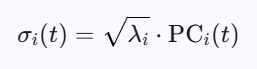

vols shape: (51, 3)


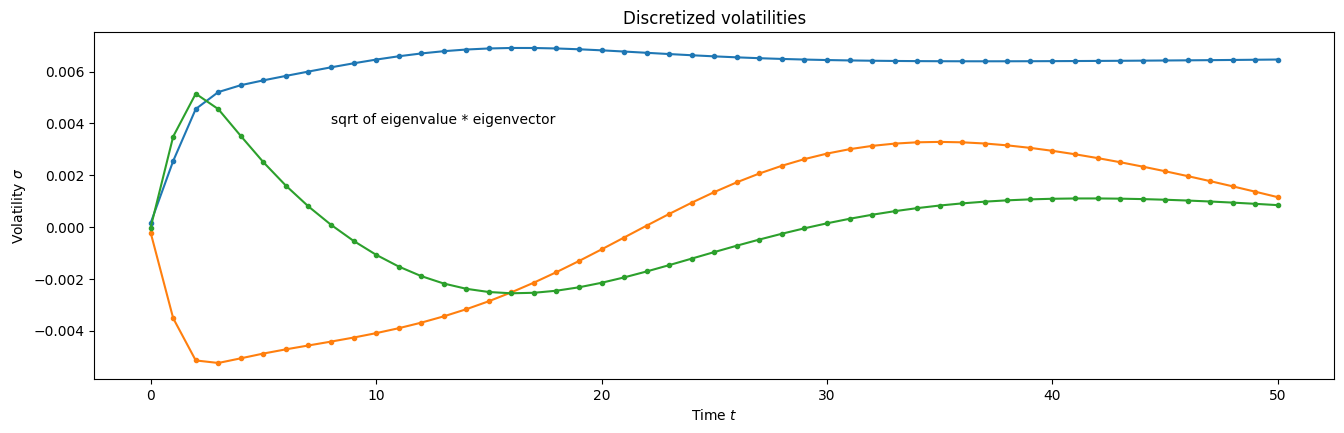

In [8]:
sqrt_eigval = matrix(princ_eigval ** .5) # volatility(sigma) = sqroot(var) = sqrt(eigenvalue)
tmp_m = vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = multiply(tmp_m, princ_comp) # multiply matrice element-wise
print('vols shape: ' + str(vols.shape))
plot(vols, marker='.'), title('Discretized volatilities'),
xlabel(r'Time $t$'), ylabel(r'Volatility $\sigma$'), text(8, 0.004, 'sqrt of eigenvalue * eigenvector'), show();


Polynomiaal example:

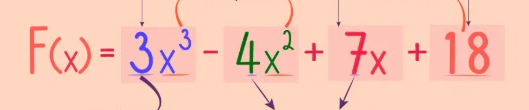

fitten (smoothing) van de volatiliteit: overbruggen van de kloof tussen historische data en een continu-tijd financiële model

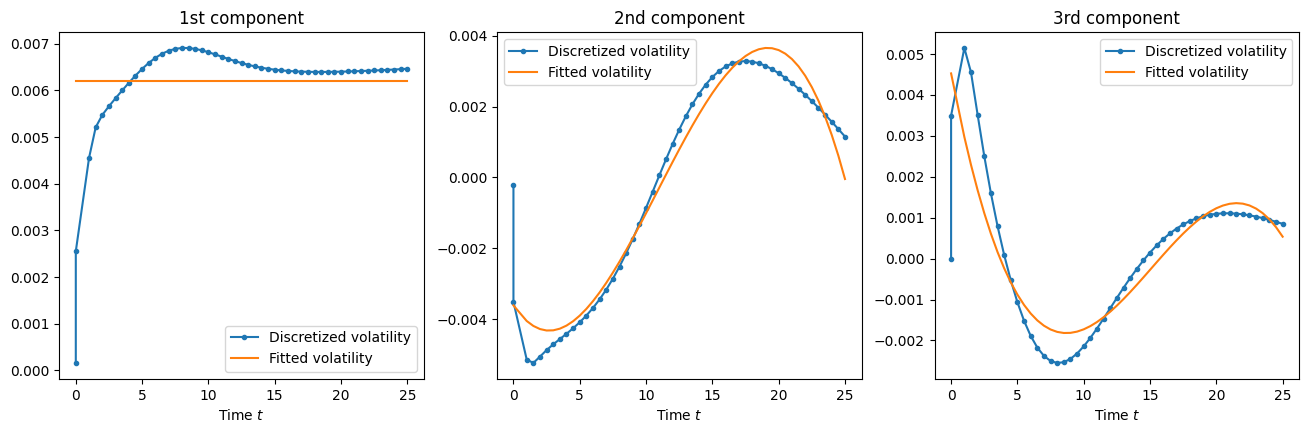

In [ ]:
def get_matrix_column(mat, i):
    return array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = array([x**i for i in reversed(range(n))])
        return sum(multiply(X, C)) # geeft in de vorm P(x) = C_n x^n + .. + C_1 x^1 + C_0 weer
    
fitted_vols = []
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(polyfit(tenors, vol, degree))    # polyfit(...) berekent de coëfficiënten (C's), PolynomialInterpolator polynomiale curve geeft formule
    plot(tenors, vol, marker='.', label='Discretized volatility')
    plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title), xlabel(r'Time $t$'), legend();
    fitted_vols.append(fitted_vol)
    
subplot(1, 3, 1), fit_volatility(0, 0, '1st component');
subplot(1, 3, 2), fit_volatility(1, 3, '2nd component');
subplot(1, 3, 3), fit_volatility(2, 3, '3rd component'); # 0, 3 en 3 weerspiegelen een empirische best practice
show()

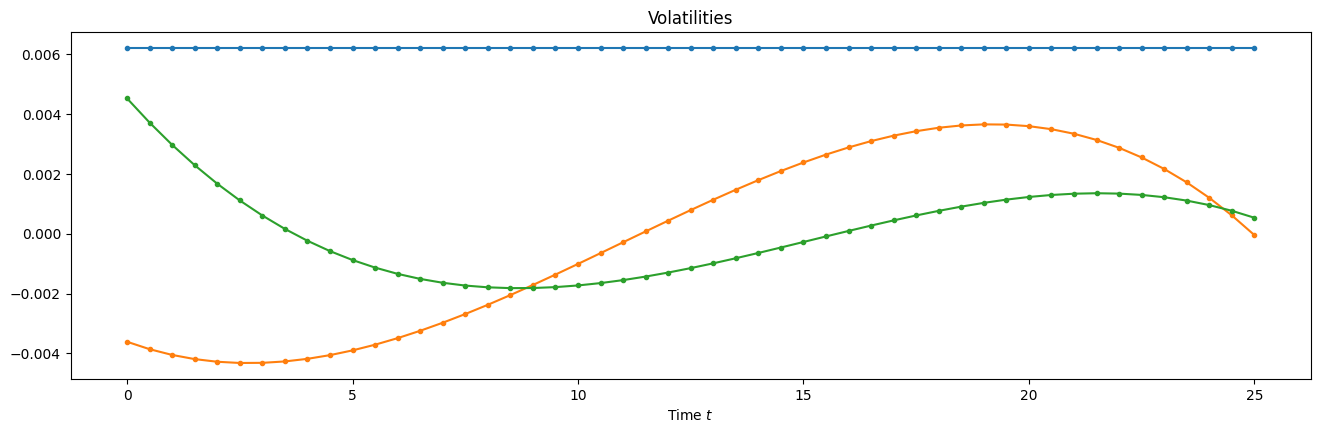

In [18]:
mc_tenors = linspace(0,25,51) # Deze array vertegenwoordigt een nieuw, fijnmazig rooster van looptijden (tenors), van 0 jaar tot 25 jaar. De oorspronkelijke historische data had mogelijk slechts 10-20 looptijden
# Discretize fitted volfuncs for the purpose of monte carlo simulation
# fitted_vol: de functies sigma_1(t), sigma_2(t), sigma_3(t), voor elke tijdseenheid
mc_vols = matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose() # fitted_vol.calc(tenor) = f(tenor)
plot(mc_tenors, mc_vols, marker='.'), xlabel(r'Time $t$'), title('Volatilities'), show();


Drift (alfa)

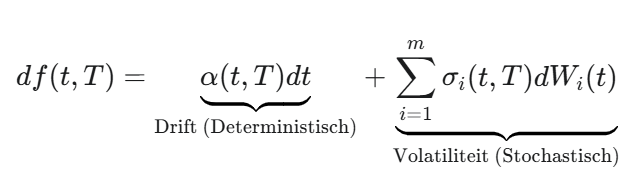
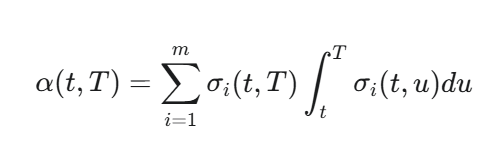

https://www.mdpi.com/2227-7390/9/2/114

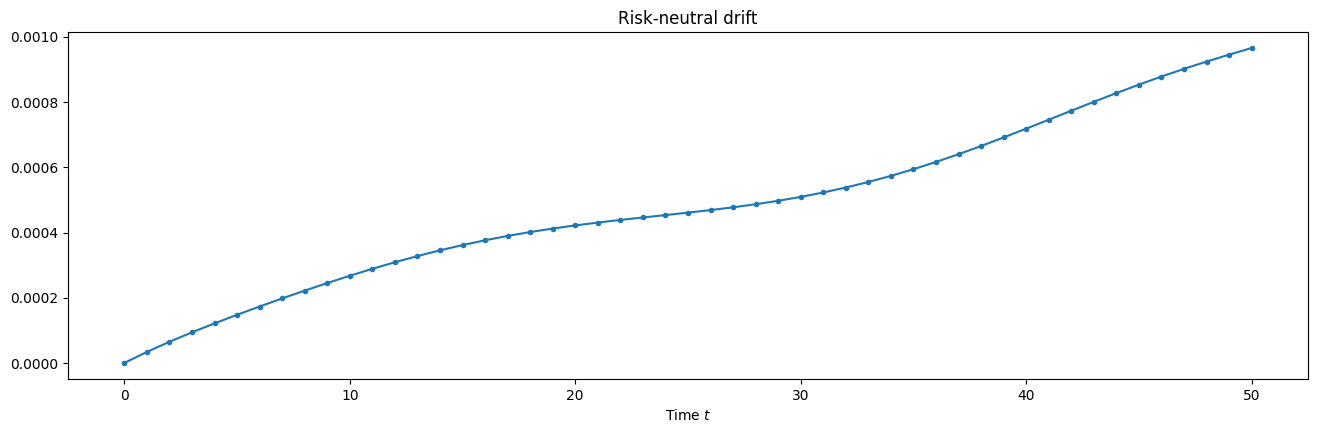

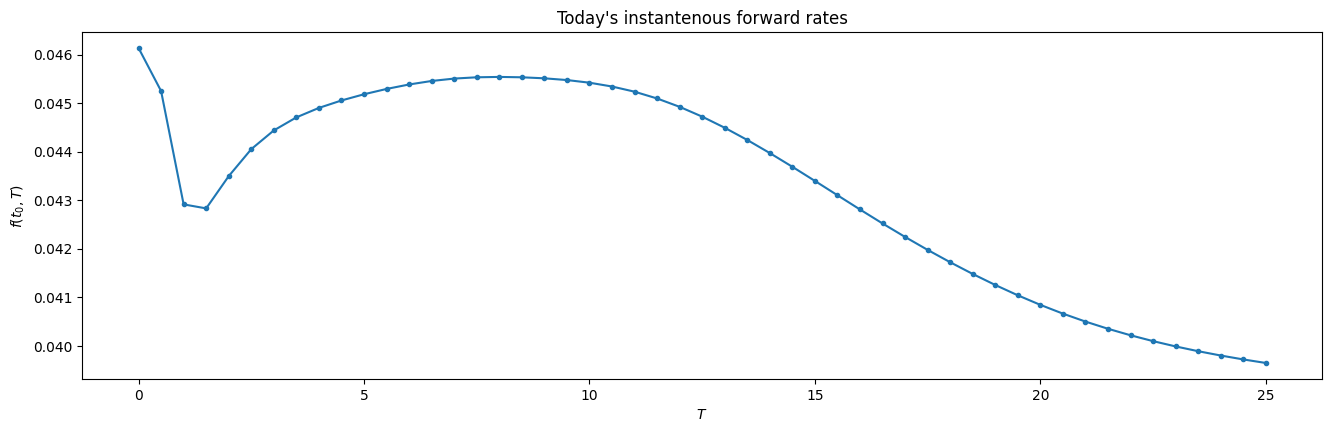

In [21]:
def integrate(f, x0, x1, dx): # simple trapezoidal rule integration
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(linspace(x0, x1, int(n))):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out

def integration_all(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator) # Als False is, stopt het en geeft AssertionError
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

mc_drift = array([integration_all(tau, fitted_vols) for tau in mc_tenors])
plot(mc_drift, marker='.'), xlabel(r'Time $t$'), title('Risk-neutral drift'), show();

curve_spot = array(hist_rates[-1,:].flatten())[0] # yield curve (instantane forward rate curve) op de meest recente observatiedatum
plot(mc_tenors, curve_spot.transpose(), marker='.'), ylabel('$f(t_0,T)$'), xlabel("$T$"), 
title('Today\'s instantenous forward rates'), show();

simuleert hoe de huidige rentes in de markt zich in de toekomst zullen ontwikkelen door kleine, stapsgewijze veranderingen toe te voegen, gebaseerd op drie krachten: de verwachte richting (drift), willekeurige schokken (volatiliteit), en een noodzakelijke wiskundige correctie (roll-down)

Om een SDE op een computer te simuleren, moet je deze omzetten in een numerieke differentievergelijking over een kleine tijdstap $\Delta t$. De methode die je code gebruikt, is de Euler-Maruyama methode (de meest voorkomende methode voor SDE's).Jouw code implementeert de volgende vergelijking (waarbij $\Delta f$ de verandering is van $f$ over de tijdstap $\Delta t$):

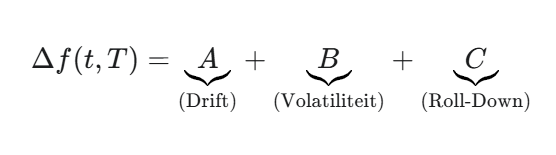
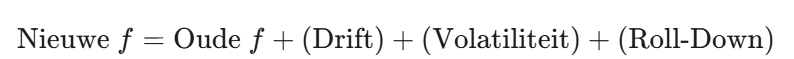

In [ ]:
def simulation(f, tenors, drift, vols, timeline):
    assert type(tenors)==ndarray
    assert type(f)==ndarray
    assert type(drift)==ndarray
    assert type(timeline)==ndarray
    assert len(f)==len(tenors)
    vols = array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copylib.copy(f)
    for it in range(1, len(timeline)):
        t = timeline[it]
        dt = t - timeline[it-1]
        sqrt_dt = sqrt(dt)
        fprev = f
        f = copylib.copy(f)
        random_numbers = [normal() for i in range(len_vols)] # dW (Willekeurigheid)
        for iT in range(len_tenors):
            # Term 1: Deterministisch (Drift), verwachte verandering: Oude Waarde + alpha(T) dt
            val = fprev[iT] + drift[iT] * dt
            # Term 2: Stochastiek (Volatiliteit/Schok)
            sum = 0
            for iVol, vol in enumerate(vols):
                sum += vol[iT] * random_numbers[iVol]
            val += sum * sqrt_dt
            # Term 3: De Roll-Down (Looptijd Verschuiving)
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

één enkel pad uit ter demonstratie

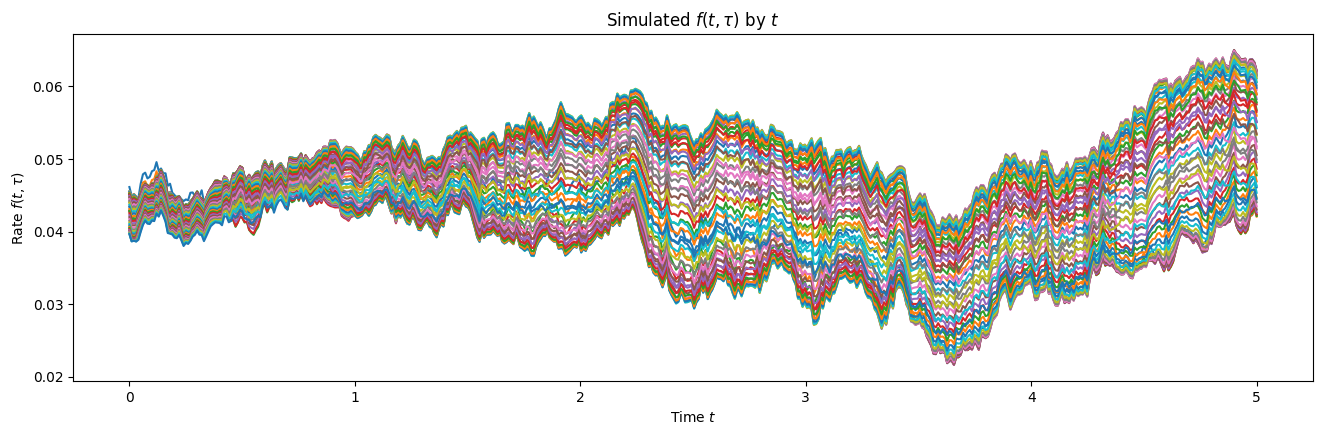

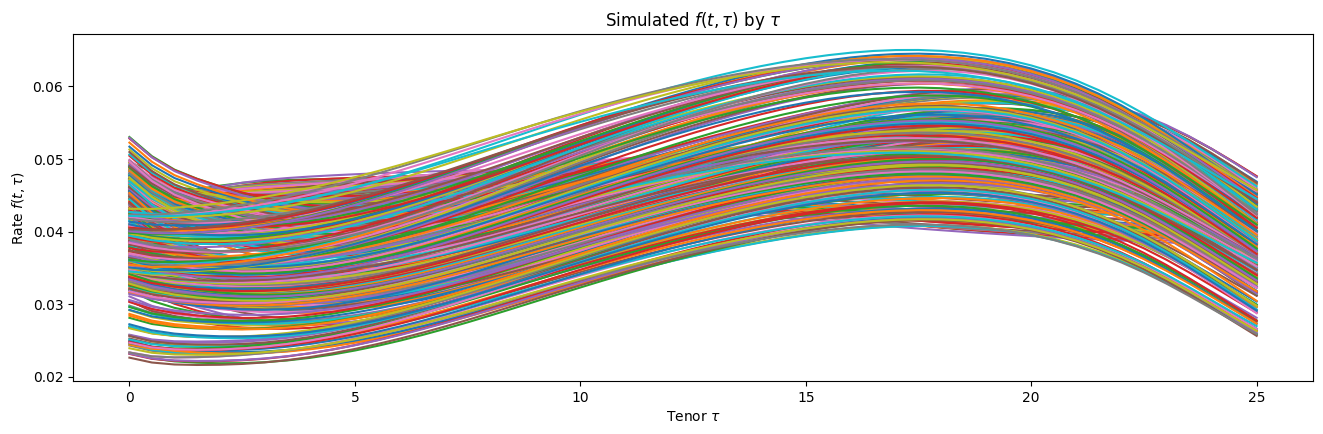

In [24]:
proj_rates = []
proj_timeline = linspace(0,5,500) # tijdsstappen voor de simulatie: over een periode van 5 jaar, verdeeld in 500 kleine stappen

for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    proj_rates.append(f)
proj_rates = matrix(proj_rates)
# voor elke maturity specifieke rente over tijd
plot(proj_timeline.transpose(), proj_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $t$'), show();
# yield curve voor elk tijdstip
plot(mc_tenors, proj_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');
title(r'Simulated $f(t,\tau)$ by $\tau$'), show();

monte carlo simulaties (met gemini geschreven)

Start Monte Carlo simulatie van de rentecurve: 100 paden over 5.0 jaar.
Simulatie voltooid.


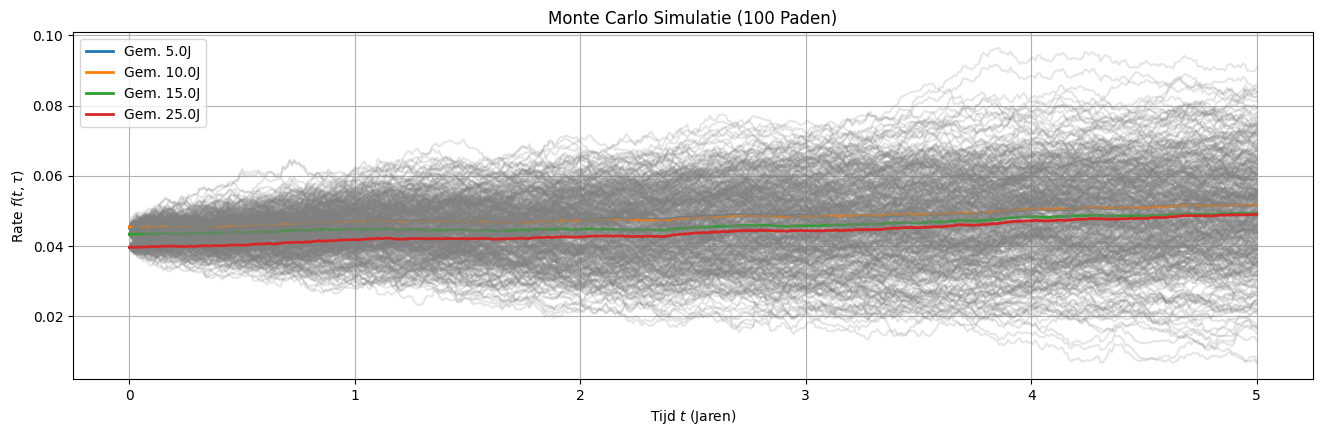

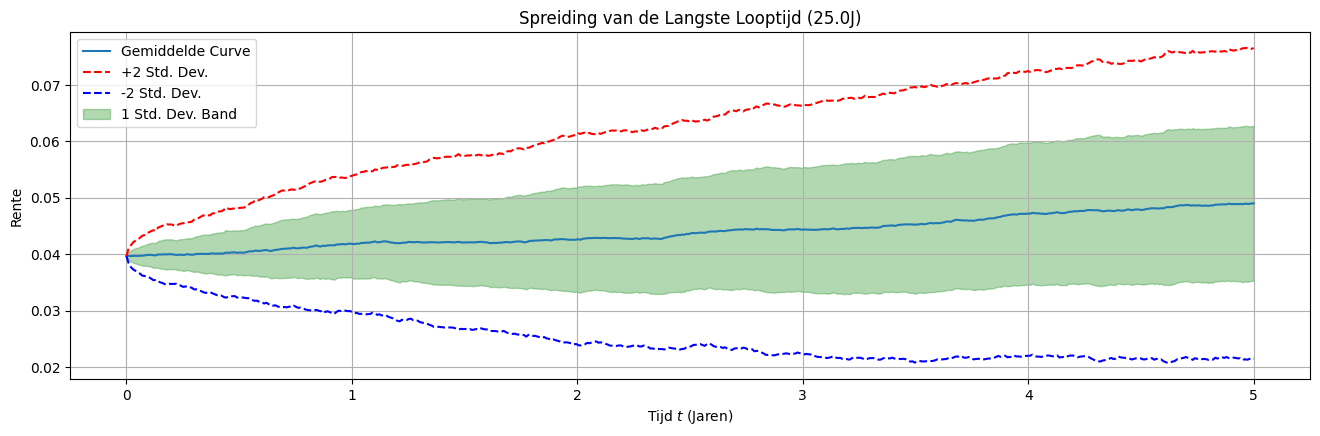

In [27]:
# --- Monte Carlo Simulatie van de Rente Curve ---

# Parameters voor de Monte Carlo run
N_SIMULATIONS = 100       # Het aantal paden dat je wilt simuleren
N_TIMESTEPS = 500         # Het aantal stappen in de tijd voor de nauwkeurigheid van elk pad
MAX_TIME = 5.0            # De periode waarover we simuleren (5 jaar)

# Definieer de tijdstappen
proj_timeline = linspace(0, MAX_TIME, N_TIMESTEPS)

# Lijst om ALLE 100 GESIMULEERDE PADEN op te slaan
# Dit zal een lijst van lijsten worden: [Paden] -> [Tijdstappen] -> [Tenors]
all_simulated_paths = []

print(f"Start Monte Carlo simulatie van de rentecurve: {N_SIMULATIONS} paden over {MAX_TIME} jaar.")

# 1. De Buitenste Monte Carlo Loop
for i in range(N_SIMULATIONS):
    # Lijst om de curve voor EEN ENKEL PAD op te slaan
    one_path_curves = []

    # 2. De Simulatie Loop (gebruikt de 'simulation' functie die je hebt gedefinieerd)
    # De generator produceert de curve in elke tijdstap.
    for t, curve_fwd in simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline):
        one_path_curves.append(curve_fwd)

    # Voeg het voltooide pad toe aan de totale resultaten
    all_simulated_paths.append(one_path_curves)

# Converteer de resultaten naar een NumPy array voor gemakkelijke manipulatie
# Dimensies: (N_SIMULATIONS, N_TIMESTEPS, len_tenors)
all_simulated_paths = array(all_simulated_paths)
print("Simulatie voltooid.")

# --- Visualisatie van de Monte Carlo Resultaten ---

# Selecteer een paar prominente looptijden (tenors) om te plotten
# We nemen de looptijd die overeenkomt met index 10, 20 en 30 (bijv. 5-jaar, 10-jaar, 15-jaar, afhankelijk van mc_tenors)
# Je kunt deze indices aanpassen
selected_tenor_indices = [10, 20, 30, -1] # De laatste index is de langste looptijd

figure()
# Plot de gesimuleerde paden voor verschillende looptijden (Time vs Rate)
for tenor_idx in selected_tenor_indices:
    # Haal de tijdreeks op voor die specifieke looptijd over alle simulaties
    # We plotten elke gesimuleerde pad voor deze ene looptijd
    tenor_rate_paths = all_simulated_paths[:, :, tenor_idx]

    # Plot alle 100 gesimuleerde paden in het grijs (alpha=0.2 maakt ze transparant)
    plot(proj_timeline, tenor_rate_paths.transpose(), color='gray', alpha=0.2)

    # Plot het gemiddelde van alle 100 paden in een duidelijke kleur
    avg_path = average(tenor_rate_paths, axis=0)
    plot(proj_timeline, avg_path, linewidth=2, label=f'Gem. {mc_tenors[tenor_idx]:.1f}J')

title(f'Monte Carlo Simulatie ({N_SIMULATIONS} Paden)')
xlabel(r'Tijd $t$ (Jaren)')
ylabel(r'Rate $f(t,\tau)$')
legend()
grid(True)
show()

# Om een betere visuele indruk te krijgen van de spreiding: Plot de spreiding (bandbreedte)
figure()
avg_path = average(all_simulated_paths[:, :, -1], axis=0) # Gemiddelde pad voor langste tenor
std_dev = std(all_simulated_paths[:, :, -1], axis=0) # Standaardafwijking voor langste tenor

plot(proj_timeline, avg_path, label='Gemiddelde Curve')
plot(proj_timeline, avg_path + 2 * std_dev, '--', color='red', label='+2 Std. Dev.')
plot(proj_timeline, avg_path - 2 * std_dev, '--', color='blue', label='-2 Std. Dev.')
fill_between(proj_timeline, avg_path - std_dev, avg_path + std_dev, color='green', alpha=0.3, label='1 Std. Dev. Band')

title(f'Spreiding van de Langste Looptijd ({mc_tenors[-1]:.1f}J)')
xlabel(r'Tijd $t$ (Jaren)')
ylabel('Rente')
legend()
grid(True)
show()

Caplet - niet relevant?

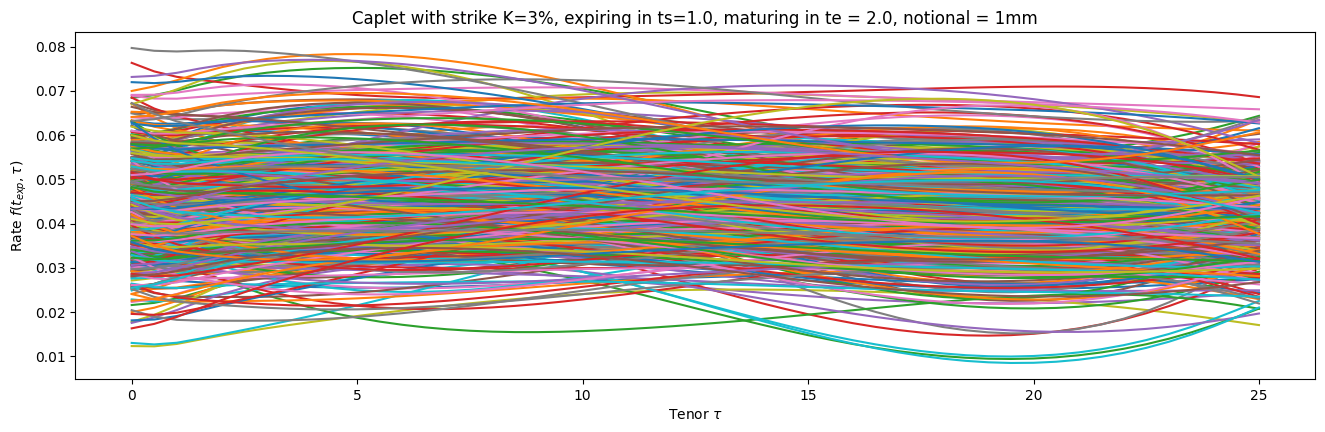

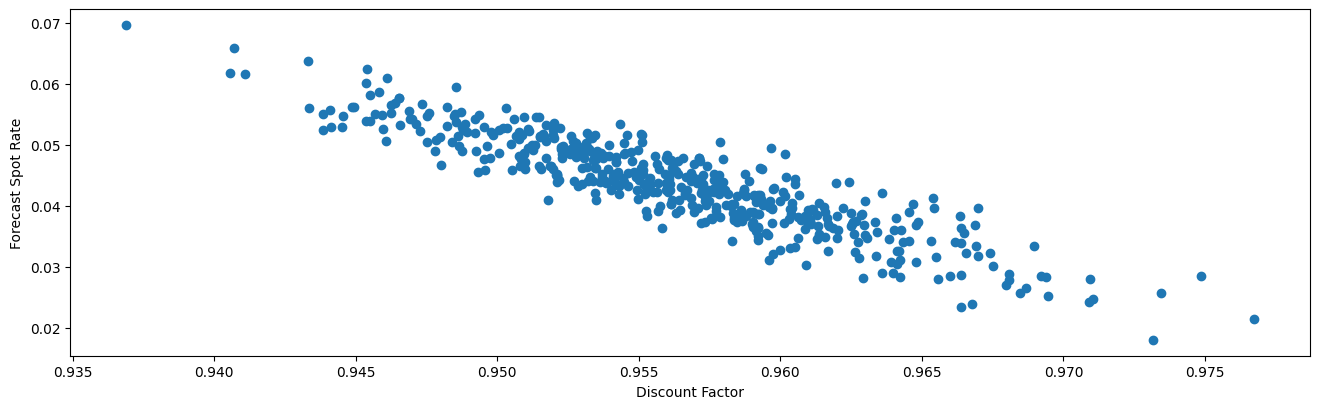

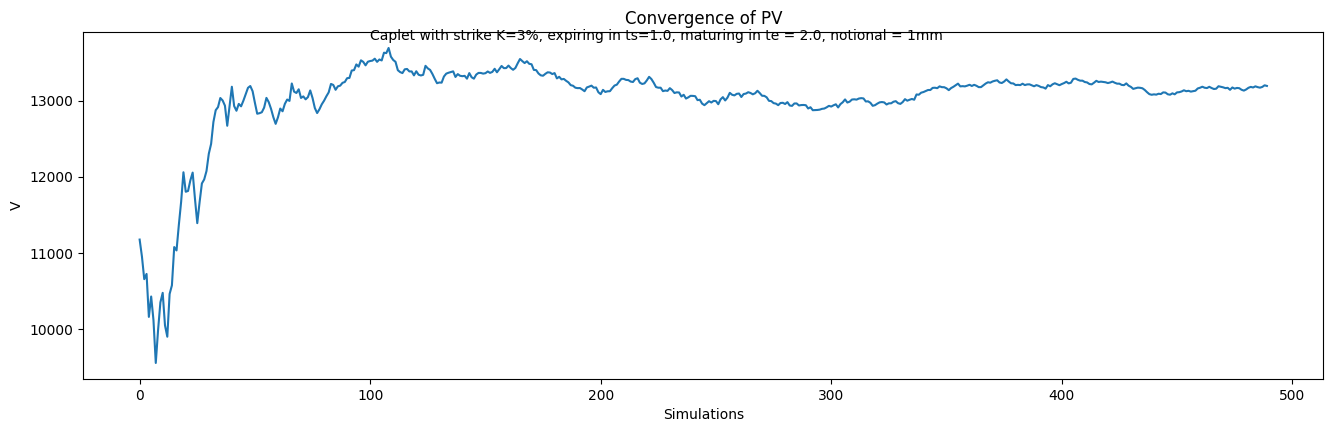

Final value: 13192.389871


In [ ]:
class Integrator:
    def __init__(self, x0, x1):
        assert x0 < x1
        self.sum, self.n, self.x0, self.x1= 0, 0, x0, x1
    def add(self, value):
        self.sum += value
        self.n += 1
    def get_integral(self):
        return (self.x1 - self.x0) * self.sum / self.n
    
t_exp, t_mat = 1., 2.
K, notional = .03, 1e6
n_simulations, n_timesteps = 500, 50

proj_timeline = linspace(0,t_mat, n_timesteps)
simulated_forecast_rates = []
simulated_df = []
simulated_pvs = []
pv_convergence_process = []
for i in range(0, n_simulations):
    rate_forecast = None                    # Forecast rate between t_exp and t_mat for this path
    rate_discount = Integrator(0, t_exp)      # cont.compounded discount rate for this path
    for t, curve_fwd in simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline):
        f_t_0 = interp(0., mc_tenors, curve_fwd)  # rate $f_t^0$
        rate_discount.add(f_t_0)
        if t>=t_exp and rate_forecast is None:  # t is expiration time
            Tau = t_mat-t_exp
            rate_forecast = Integrator(0, Tau) # integrate all inst.fwd.rates from 0 till 1Y tenor to get 1Y spot rate
            for s in linspace(0, Tau, 15): # $\int_0^T f(t,s)ds$
                f_texp_s = interp(s, mc_tenors, curve_fwd)
                rate_forecast.add(f_texp_s) 
            rate_forecast = rate_forecast.get_integral()
    plot(mc_tenors, curve_fwd), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t_{exp},\tau)$'),
    title('Caplet with strike K=3%, expiring in ts=1.0, maturing in te = 2.0, notional = 1mm');   # Plot forward curve at expiration
    df = exp(-rate_discount.get_integral())     # Discount factor
    simulated_forecast_rates.append(rate_forecast)
    simulated_df.append(df)
    pv = max(0, rate_forecast - K) * (t_mat-t_exp) * notional * df
    simulated_pvs.append(pv)
    pv_convergence_process.append(average(simulated_pvs))
show()

#
scatter(simulated_df, simulated_forecast_rates), xlabel('Discount Factor'), ylabel('Forecast Spot Rate')
show()

#
plot(pv_convergence_process[10:]), title('Convergence of PV'), xlabel("Simulations"), ylabel("V"),
text(100, 13800, 'Caplet with strike K=3%, expiring in ts=1.0, maturing in te = 2.0, notional = 1mm'), show();
print("Final value: %f" % pv_convergence_process[-1])